<a href="https://colab.research.google.com/github/shahensha5624/Landscape-Classification/blob/main/Landscape_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchmetrics import Accuracy # Now this import should work
import matplotlib.pyplot as plt
import time

In [ ]:
dataset_path = '/content/drive/MyDrive/Landscapes_1/Aerial_Landscapes'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class LandscapeClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(LandscapeClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)

        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
num_classes = len(full_dataset.classes)
model = LandscapeClassifier(num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20


In [ ]:
train_accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
val_accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy(outputs, labels)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_accuracy(outputs, labels)

    scheduler.step()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_acc = train_accuracy.compute().item()
    val_acc = val_accuracy.compute().item()

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    train_accuracy.reset()
    val_accuracy.reset()

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%')
    print(f'Epoch Time: {epoch_time:.2f} seconds')
    print('-' * 50)

Epoch [1/20]:
Train Loss: 1.3454, Train Accuracy: 58.08%
Val Loss: 0.9010, Val Accuracy: 71.17%
Epoch Time: 1339.75 seconds
--------------------------------------------------
Epoch [2/20]:
Train Loss: 0.8544, Train Accuracy: 73.40%
Val Loss: 0.7018, Val Accuracy: 79.20%
Epoch Time: 106.29 seconds
--------------------------------------------------
Epoch [3/20]:
Train Loss: 0.6317, Train Accuracy: 80.88%
Val Loss: 0.4562, Val Accuracy: 85.92%
Epoch Time: 109.70 seconds
--------------------------------------------------
Epoch [4/20]:
Train Loss: 0.5427, Train Accuracy: 83.78%
Val Loss: 0.5504, Val Accuracy: 83.35%
Epoch Time: 111.34 seconds
--------------------------------------------------
Epoch [5/20]:
Train Loss: 0.4748, Train Accuracy: 85.92%
Val Loss: 0.6773, Val Accuracy: 81.23%
Epoch Time: 111.58 seconds
--------------------------------------------------
Epoch [6/20]:
Train Loss: 0.4280, Train Accuracy: 86.88%
Val Loss: 0.3266, Val Accuracy: 89.98%
Epoch Time: 111.30 seconds
------

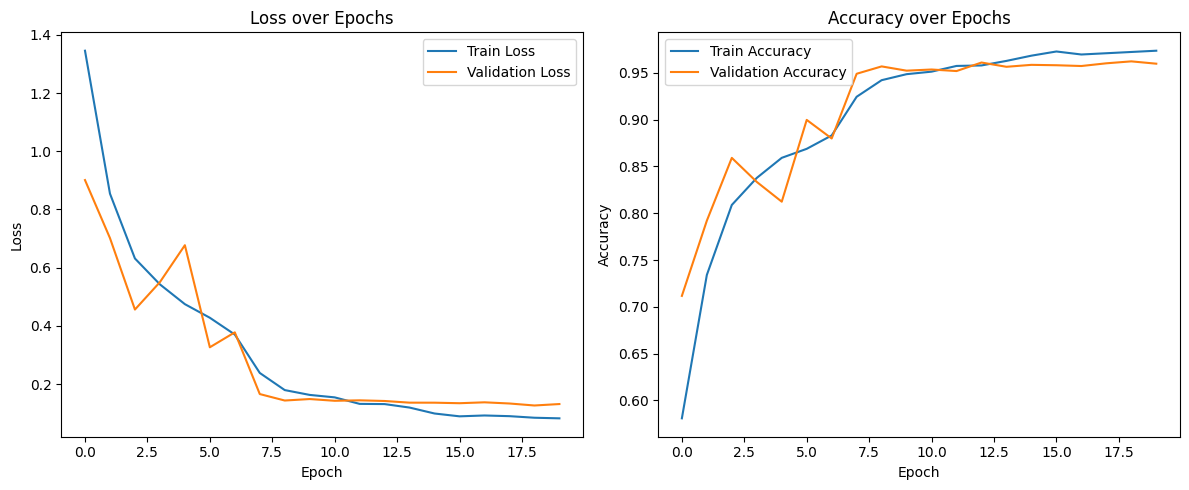

In [ ]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

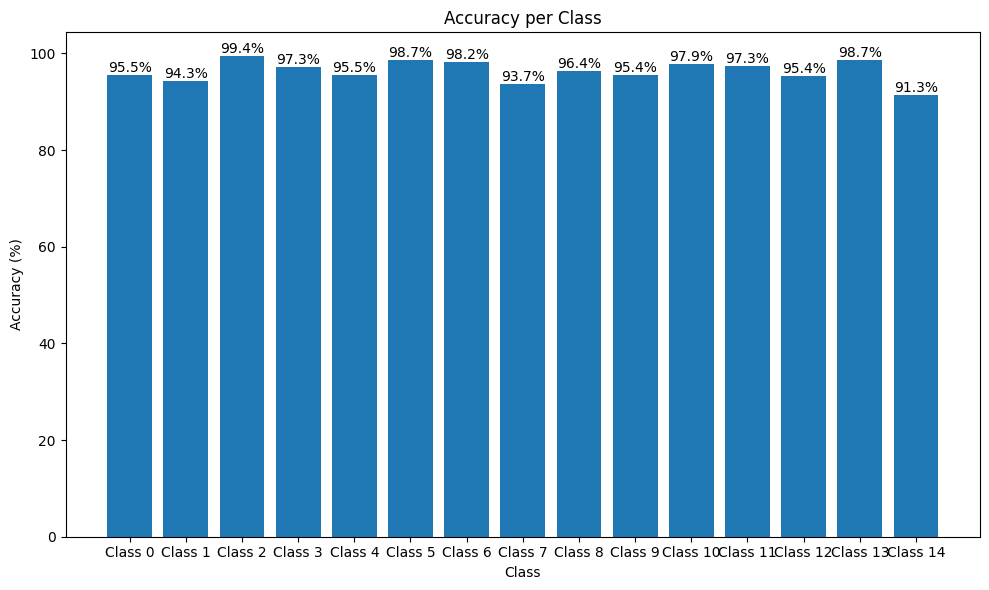

Class-wise Accuracies:
Class 0: 95.45%
Class 1: 94.34%
Class 2: 99.39%
Class 3: 97.26%
Class 4: 95.54%
Class 5: 98.68%
Class 6: 98.19%
Class 7: 93.71%
Class 8: 96.36%
Class 9: 95.43%
Class 10: 97.87%
Class 11: 97.33%
Class 12: 95.39%
Class 13: 98.73%
Class 14: 91.33%


In [ ]:
def compute_class_accuracy(model, dataloader, device):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    class_accuracies = [
        100 * class_correct[i] / class_total[i]
        for i in range(num_classes)
    ]
    return class_accuracies

class_accuracies = compute_class_accuracy(model, val_loader, device)

plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), class_accuracies)
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.xticks(range(num_classes), [f'Class {i}' for i in range(num_classes)])

for i, acc in enumerate(class_accuracies):
    plt.text(i, acc, f'{acc:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Class-wise Accuracies:")
for i, acc in enumerate(class_accuracies):
    print(f"Class {i}: {acc:.2f}%")

In [ ]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import mobilenet_v3_large

model = mobilenet_v3_small(pretrained=True)
model = mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 77.6MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are d

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = models.mobilenet_v3_small(pretrained=True)
num_classes = len(full_dataset.classes)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


def train_model(model, criterion, optimizer, scheduler, num_epochs=20):

    total_start_time = time.time()
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):

        epoch_start_time = time.time()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)


        model.train()
        train_loss = 0.0
        train_corrects = 0
        train_start_time = time.time()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()


            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_time = time.time() - train_start_time


        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_start_time = time.time()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_time = time.time() - val_start_time


        epoch_train_loss = train_loss / len(train_dataset)
        epoch_train_acc = train_corrects.double() / len(train_dataset)
        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)


        scheduler.step()


        epoch_time = time.time() - epoch_start_time


        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        print(f'Train Time: {train_time:.2f}s, Val Time: {val_time:.2f}s')
        print(f'Epoch Total Time: {epoch_time:.2f}s')


        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model.state_dict(), 'best_mobilenetv3_model.pth')


    total_training_time = time.time() - total_start_time
    print(f'Total Training Time: {total_training_time:.2f}s')
    print(f'Average Epoch Time: {total_training_time/num_epochs:.2f}s')

    return model


def analyze_performance():

    if torch.cuda.is_available():
        print("GPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")


    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("Model Parameters:")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")


trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


analyze_performance()

Epoch 1/20
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4349 Acc: 0.8639
Val Loss: 0.3393 Acc: 0.8944
Train Time: 54.01s, Val Time: 11.88s
Epoch Total Time: 65.88s
Epoch 2/20
----------
Train Loss: 0.2055 Acc: 0.9345
Val Loss: 0.2408 Acc: 0.9263
Train Time: 59.80s, Val Time: 13.26s
Epoch Total Time: 73.07s
Epoch 3/20
----------
Train Loss: 0.1638 Acc: 0.9486
Val Loss: 0.1971 Acc: 0.9354
Train Time: 52.67s, Val Time: 12.20s
Epoch Total Time: 64.87s
Epoch 4/20
----------
Train Loss: 0.1199 Acc: 0.9604
Val Loss: 0.2245 Acc: 0.9312
Train Time: 49.95s, Val Time: 11.92s
Epoch Total Time: 61.87s
Epoch 5/20
----------
Train Loss: 0.1139 Acc: 0.9625
Val Loss: 0.2696 Acc: 0.9234
Train Time: 50.27s, Val Time: 11.40s
Epoch Total Time: 61.66s
Epoch 6/20
----------
Train Loss: 0.1212 Acc: 0.9614
Val Loss: 0.1686 Acc: 0.9536
Train Time: 49.94s, Val Time: 11.81s
Epoch Total Time: 61.76s
Epoch 7/20
----------
Train Loss: 0.1174 Acc: 0.9633
Val Loss: 0.2283 Acc: 0.9337
Train Time: 51.15s, Val Time: 10.60s
Epoch Total Time: 61.75s
Epoch 8/20
---

In [ ]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Accuracy on test set: {accuracy:.2f}%")
    return accuracy


In [ ]:
final_accuracy = evaluate_accuracy(model, val_loader, device)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Final Accuracy on test set: 97.93%


In [ ]:
# Choose the file name based on your model
model_name = "Landscape_Classifier.pth"  # or "resnet50_best.pth"

# Save the model (state_dict saves only the weights)
torch.save(model.state_dict(), model_name)
print(f"Model saved as {model_name}")


Model saved as Landscape_Classifier.pth


In [ ]:
from google.colab import files

# Download the model to your local system
files.download(model_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>